In [63]:
from sklearn.datasets import fetch_20newsgroups
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.decomposition import TruncatedSVD
import __init__
from src.preprocessing_functions import processing

In [315]:
categories = ['rec.sport.baseball', 'rec.sport.hockey'] 
twenty_train = fetch_20newsgroups(subset= 'train', categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42, remove=('headers', 'footers', 'quotes'))

In [316]:
twenty_train.target_names

['rec.sport.baseball', 'rec.sport.hockey']

In [317]:
train_data = pd.DataFrame(twenty_train.data, columns=['Text'])
train_data['target'] = twenty_train.target
test_data = pd.DataFrame(twenty_test.data, columns=['Text'])
test_data['target'] = twenty_test.target

In [318]:
%%time
train_data['text_preprocessing'] = [processing(text) for text in train_data['Text']]
train_data['text_preprocessing'] = [' '.join(map(str, l)) for l in train_data['text_preprocessing']]

CPU times: user 2min 19s, sys: 594 ms, total: 2min 20s
Wall time: 2min 20s


In [319]:
%%time
test_data['text_preprocessing'] = [processing(text) for text in test_data['Text']]
test_data['text_preprocessing'] = [' '.join(map(str, l)) for l in test_data['text_preprocessing']]

CPU times: user 1min 30s, sys: 380 ms, total: 1min 30s
Wall time: 1min 30s


In [322]:
train_data.head()

,Text,target,text_preprocessing
0,\n\nThe tribe will be in town from April 16 to...,0,tribe town numero always available though many...
1,This game would have been great as part of a d...,1,game would great part double header league wou...
2,"My god, hope we don't have to put up with this...",0,god hope put kind junk season many home numero...
3,\n\n\nI heard it will be the Minnesota-Detroit...,1,game know time though
4,I would like to make everyone aware that in wi...,0,would like make everyone aware winning west le...


In [321]:
train_data.target[500:] = -1

/home/luiz/Documentos/meetup_active/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [294]:
train_data.reset_index(inplace=True)

In [323]:
train_data

,Text,target,text_preprocessing
0,\n\nThe tribe will be in town from April 16 to...,0,tribe town numero always available though many...
1,This game would have been great as part of a d...,1,game would great part double header league wou...
2,"My god, hope we don't have to put up with this...",0,god hope put kind junk season many home numero...
3,\n\n\nI heard it will be the Minnesota-Detroit...,1,game know time though
4,I would like to make everyone aware that in wi...,0,would like make everyone aware winning west le...
...,...,...,...
1192,\nQuestion:\nIf a team uses 40 players in a se...,-1,question team numero season merely divide tota...
1193,Does anyone have the NHL STANDINGS for March 2...,-1,anyone march need immediately project please p...
1194,The Dodgers have been shopping Harris to other...,-1,shopping quest left handed pitching far person...
1195,\n\nI'm not quite sure how these numbers are g...,-1,quite sure neutral park bo slugging tend drop ...


In [296]:
pipe = Pipeline(steps=[
    ('counts', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

In [324]:
X_sparse = pipe.fit_transform(train_data.text_preprocessing)

In [326]:
# Define our LSA transformer and fit it onto our dataset.
svd = TruncatedSVD(n_components=2, random_state=42)
data = svd.fit_transform(X_sparse) 

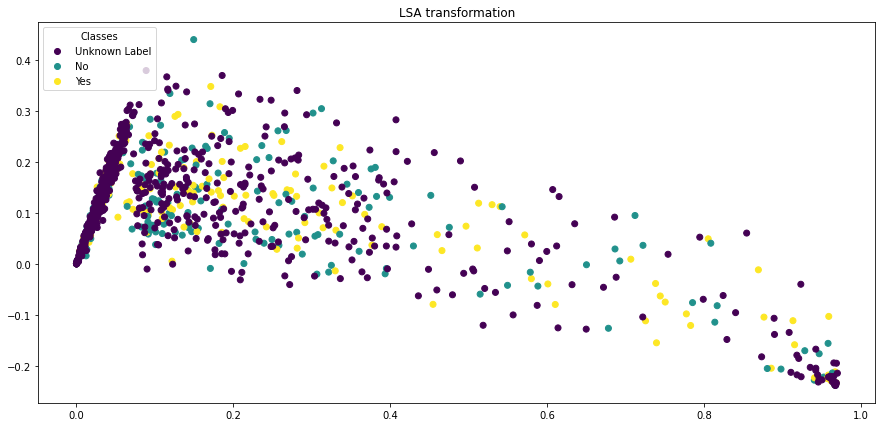

In [360]:
# Isolate the data we'll need for plotting.
x_component, y_component = data[:, 0], data[:, 1]

# Plot our dimensionality-reduced (via LSA) dataset.
fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(x=x_component, y=y_component, c=train_data.target, cmap='viridis')
classes = ['Unknown Label', 'No', 'Yes']

legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=classes,
                    loc="upper left", title="Classes")
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.title('LSA transformation')
plt.show()

In [328]:
X_pool = train_data.query("target == -1")

In [336]:
X_pool = X_pool.reset_index().rename_axis('index_sparse').reset_index()

In [337]:
X_pool.head()

,index_sparse,index,Text,target,text_preprocessing
0,0,500,"I Love it how all of these people are ""blaming...",-1,love people blaming success weak division look...
1,1,501,\nJudging by the way the Reds' pitchers have p...,-1,way thus far zone size grape numero numero
2,2,502,"\n\n\nNow, on the other hand, Juan Gonzales pr...",-1,hand probably shot numero actually might eric ...
3,3,503,"\nLinares has not defected; as I pointed out, ...",-1,pointed player defect first surprise long pool...
4,4,504,The Blackhawks shall triumph.,-1,shall triumph


In [338]:
X_pool.shape

(697, 5)

In [339]:
X_pool_sparse = pipe.transform(X_pool.text_preprocessing)

In [340]:
X_pool_sparse

<697x5472 sparse matrix of type '<class 'numpy.float64'>'
	with 24683 stored elements in Compressed Sparse Row format>

In [341]:
svm = SVC(probability=True)

**Parameters**:	

**classifier** – The classifier for which the labels are to be queried.

**X** – The pool of samples to query from.

**n_instances** – Number of samples to be queried.

**random_tie_break** – If True, shuffles utility scores to randomize the order. This can be used to break the tie when the highest utility score is not unique.

**uncertainty_measure_kwargs** – Keyword arguments to be passed for the uncertainty measure function.

Returns:	

The indices of the instances from X chosen to be labelled; the instances from X chosen to be labelled.

In [342]:
index_list = list(uncertainty_sampling(svm, X_pool_sparse, n_instances=50)[0])

In [343]:
uncertainty_sampling(svm, X_pool_sparse, n_instances=50)

(array([478, 480, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448,
        449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461,
        462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474,
        475, 476, 477, 436, 479, 507, 506, 509, 508, 511, 505]),
 <50x5472 sparse matrix of type '<class 'numpy.float64'>'
 	with 1722 stored elements in Compressed Sparse Row format>)

In [348]:
X_pool_query = X_pool[X_pool.index_sparse.isin(index_list)]

In [352]:
X_pool_query.head()

,index_sparse,index,Text,target,text_preprocessing
436,436,936,How long has Don Cherry been a student at SFU?...,-1,long cherry student arche bunker please keep r...
438,438,938,\nYou can't be serious! I and many of my coll...,-1,serious many received bad roger fact roger hoc...
439,439,939,\n\tI loved the ABC coverage. The production w...,-1,coverage production excellent appearance excel...
440,440,940,ATTN: Those who live inthe Philadelphia Metro ...,-1,live area back listening remember morning talk...
441,441,941,"\n\tWell, Druce pretty much sucked when he was...",-1,well pretty much one good season oh well notor...


In [355]:
train_data[train_data.index.isin(list(X_pool_query['index']))].head()

,Text,target,text_preprocessing
936,How long has Don Cherry been a student at SFU?...,-1,long cherry student arche bunker please keep r...
938,\nYou can't be serious! I and many of my coll...,-1,serious many received bad roger fact roger hoc...
939,\n\tI loved the ABC coverage. The production w...,-1,coverage production excellent appearance excel...
940,ATTN: Those who live inthe Philadelphia Metro ...,-1,live area back listening remember morning talk...
941,"\n\tWell, Druce pretty much sucked when he was...",-1,well pretty much one good season oh well notor...


In [356]:
X_pool_query_sparse = pipe.transform(X_pool_query.text_preprocessing) 

In [357]:
X_pool_query_sparse_svd = svd.transform(X_pool_query_sparse) 

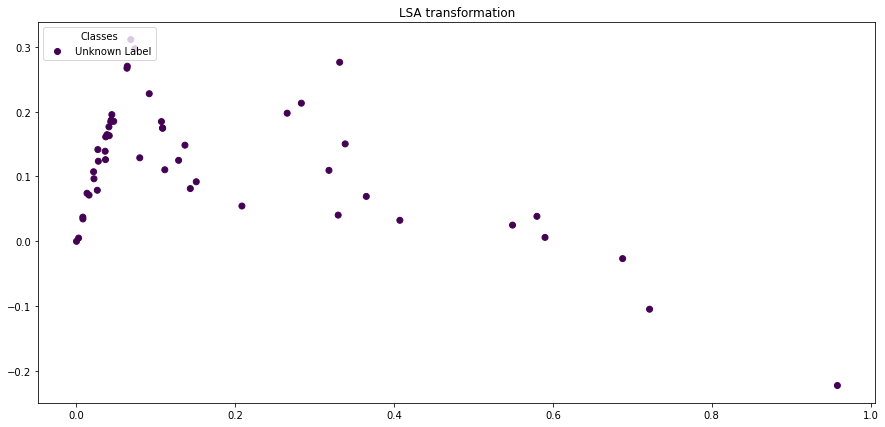

In [359]:
# Isolate the data we'll need for plotting.
x_component, y_component = X_pool_query_sparse_svd[:, 0], X_pool_query_sparse_svd[:, 1]

# Plot our dimensionality-reduced (via LSA) dataset.
fig, ax = plt.subplots(figsize=(15,7))
scatter = ax.scatter(x=x_component, y=y_component, c=testelodoi.target, cmap='viridis')
classes = ['Unknown Label']

legend1 = ax.legend(handles=scatter.legend_elements()[0], labels=classes,
                    loc="upper left", title="Classes")
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.6)
plt.title('LSA transformation')
plt.show()